## Containment Index

For each simulated read, I define a containment index, which is a measure of how contained it is.  For a read which is contained, it is based on the extra length of the read which contains it.  Formally, if a read containing a given read R extends past the read by x bases on the left and y bases on the right, the containment index of R is the harmonic mean of x and y.  In the case of reads which are contained by multiple other reads, the maximum value of the containment index is used.  For reads which are not contained by another read, the containment index represents the minimum number of bases which would need to be removed from the ends of the read in order for some other read to contain it.  To distinguish these from contained reads and to maintain the property that a higher containment index is associated with a higher degree of containment, the index is multiplied by -1 for uncontained reads.

## Distribution of Containment Index
I simulated 30x coverage on a section of the human genome with length 5 Mbp and observed the distribution of the containment across these reads.  The length distribution drawn from was based on Nanopore data from the arabidopsis genome.  This dataset had ~17.5k reads, with about 97% of them being contained.  I  looked at the overall distribution, as well as the separate distributions among reads which my software determined to be contained or uncontained.

In [1]:
import matplotlib.pyplot as plt

fn = 'simulatedscores.txt'

buckets = [1000 * i for i in range(-40, 40)]

xs = []

numContained,  numUncontained = 0, 0

nameToScore = dict()

with open(fn) as f:
    for line in f:
        tokens = line.split()
        curScore = int(tokens[1])
        xs.append(curScore)
        nameToScore[tokens[0]] = curScore
        if curScore >= 0:
            numContained += 1
        else:
            numUncontained += 1
                  
print('Number of contained reads: ' + str(numContained))
print('Number of uncontained reads: ' + str(numUncontained))

plt.hist(xs, bins = buckets)
plt.title('Containment Index')
plt.show()

Number of contained reads: 17144
Number of uncontained reads: 601


<Figure size 640x480 with 1 Axes>

Below is the same histogram, but with colors indicating the reads my software labelled as contained vs uncontained.

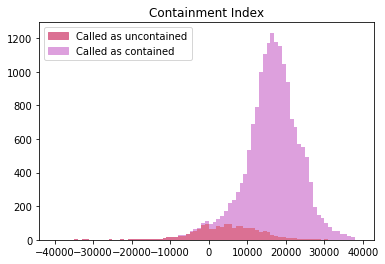

In [2]:
import matplotlib.patches as mpatches

yesVals = []
noVals = []

resultsfn = 'uncontained.txt'

yes = set()

with open(resultsfn) as f:
    for line in f:
        yes.add(line.split()[0])

for a in nameToScore:
    b = nameToScore[a]
    if a in yes:
        yesVals.append(b)
    else:
        noVals.append(b)
        
colors = ['palevioletred', 'plum']
        
plt.hist([yesVals, noVals], color = colors , bins = buckets, stacked = True)

labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.legend(handles=legendHandles)
plt.title('Containment Index')

plt.show()

## Containment Threshold
When determining which reads are contained, I use their min hash sketeches to determine a containment threshold for each read.  This represents the proportion of kmers in that read's sketch which are contained in some other read's sketch (taking the maximum proportion over all other reads).  Note that in general this  proportion will be low for  large kmers because of read errors preventing instances of a kmer from remaining identical.  Here I used 15-mers and filteredout reads with a containment threshold higher than 0.02

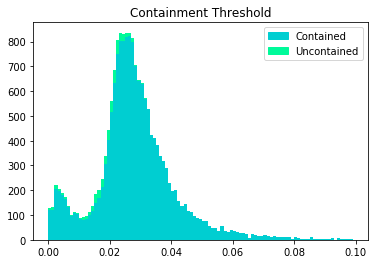

In [3]:
containedCt = []
uncontainedCt = []
nameToThreshold = dict()

ctFn = 'containment_debug.txt'

with open(ctFn) as f:
    for line in f:
        tokens = line.split()
        nameToThreshold[tokens[0]] = float(tokens[1])
        if nameToScore[tokens[0]] > 0:
            containedCt.append(float(tokens[1]))
        else:
            uncontainedCt.append(float(tokens[1]))
            

nlabels = ['Contained', 'Uncontained']
ncolors = ['darkturquoise', 'mediumspringgreen']

plt.hist([containedCt, uncontainedCt], color = ncolors, bins = [0.001 * i for i in range(0, 100)], stacked = True)

nlh = []
for i in range(0, len(ncolors)):
    nlh.append(mpatches.Patch(color=ncolors[i], label=nlabels[i]))
plt.legend(handles=nlh)
plt.title('Containment Threshold')
plt.show()

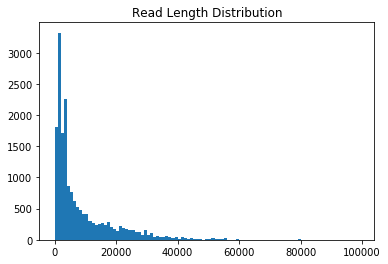

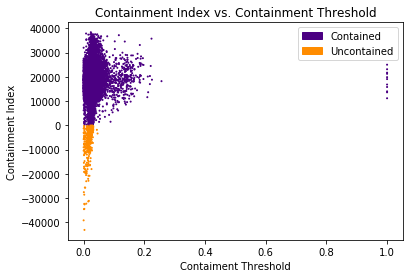

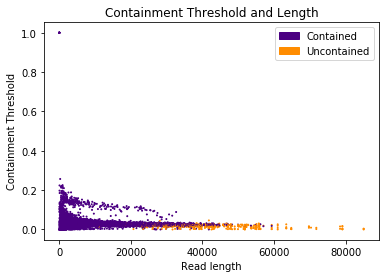

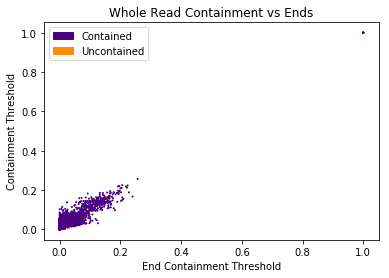

In [4]:
cts = []
cis = []
lens = []
colors = []
starts = []
ends = []
minEnd = []
curColors = ['indigo', 'darkorange']
names = []

with open(ctFn) as f:
    for line in f:
        tokens = line.split()
        names.append(tokens[0])
        score = float(nameToScore[tokens[0]])
        cts.append(float(tokens[1]))
        starts.append(float(tokens[2]))
        ends.append(float(tokens[3]))
        minEnd.append(min(float(tokens[2]), float(tokens[3])))
        lens.append(int(tokens[4]))
        cis.append(score)
        if score > 0:
            colors.append(curColors[0])
        else:
            colors.append(curColors[1])
            
plt.hist(lens, bins = [1000 * i for i in range(0, 100)])
plt.title('Read Length Distribution')
plt.savefig('rls.png')
plt.show()
plt.clf()
plt.cla()
plt.close()
            
nlh = []
for i in range(0, len(curColors)):
    nlh.append(mpatches.Patch(color=curColors[i], label=nlabels[i]))
plt.legend(handles=nlh)
plt.scatter(cts, cis, s = 1, c = colors)
plt.title('Containment Index vs. Containment Threshold')
plt.xlabel('Contaiment Threshold')
plt.ylabel('Containment Index')
plt.savefig('cict.png')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(lens, cts, s = 1, c = colors)
plt.legend(handles=nlh)
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.title('Containment Threshold and Length')
plt.savefig('ctl.png')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(minEnd, cts, s = 1, c = colors)
plt.legend(handles=nlh)
plt.xlabel('End Containment Threshold')
plt.ylabel('Containment Threshold')
plt.title('Whole Read Containment vs Ends')
plt.savefig('ctend.png')
plt.show()
plt.clf()
plt.cla()
plt.close()


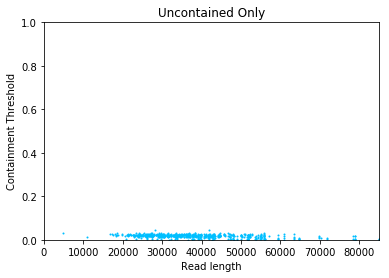

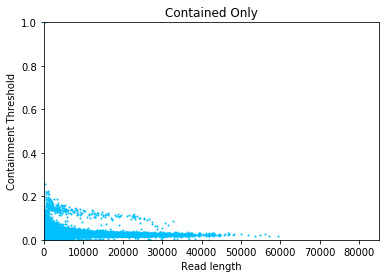

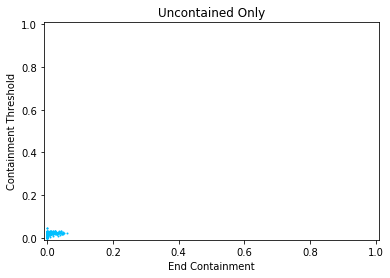

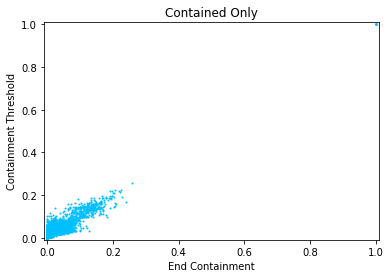

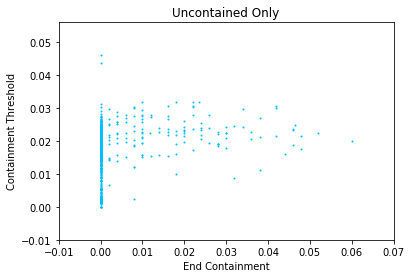

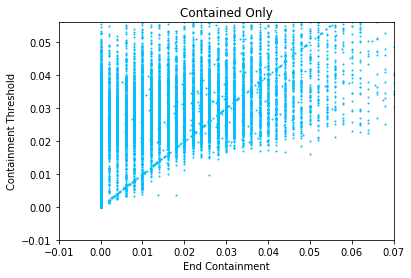

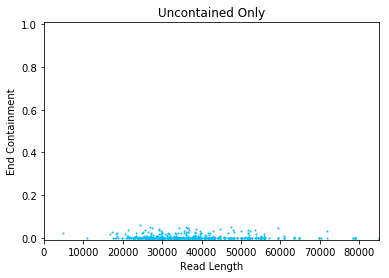

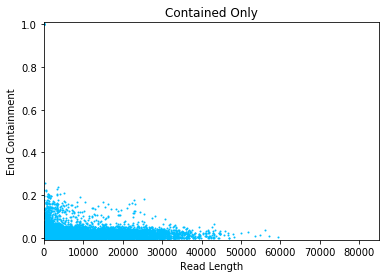

In [5]:
uncontainedCts = []
uncontainedLens = []
uncontainedEnds = []

containedCts = []
containedLens = []
containedEnds = []

realTp = 0
realFp = 0
realTn = 0
realFn = 0

for i in range(len(cts)):
    if names[i] in yes:
        if cis[i] >= 0:
            realFn += 1
        else:
            realTn += 1
    else:
        if cis[i] >= 0:
            realTp += 1
        else:
            realFp += 1

for i in range(len(cts)):
    if cis[i] < 0:
        uncontainedCts.append(cts[i])
        uncontainedLens.append(lens[i])
        uncontainedEnds.append(minEnd[i])
    else:
        containedCts.append(cts[i])
        containedLens.append(lens[i])
        containedEnds.append(minEnd[i])
        
plt.scatter(uncontainedLens, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(uncontainedEnds, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('End Containment')
plt.ylabel('Containment Threshold')
plt.xlim(min(minEnd) - 0.01, max(minEnd) + 0.01)
plt.ylim(min(cts) - 0.01, max(cts) + 0.01)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedEnds, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('End Containment')
plt.ylabel('Containment Threshold')
plt.xlim(min(minEnd) - 0.01, max(minEnd) + 0.01)
plt.ylim(min(cts) - 0.01, max(cts) + 0.01)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(uncontainedEnds, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('End Containment')
plt.ylabel('Containment Threshold')
plt.xlim(min(uncontainedEnds) - 0.01, max(uncontainedEnds) + 0.01)
plt.ylim(min(uncontainedCts) - 0.01, max(uncontainedCts) + 0.01)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedEnds, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('End Containment')
plt.ylabel('Containment Threshold')
plt.xlim(min(uncontainedEnds) - 0.01, max(uncontainedEnds) + 0.01)
plt.ylim(min(uncontainedCts) - 0.01, max(uncontainedCts) + 0.01)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(uncontainedLens, uncontainedEnds, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('Read Length')
plt.ylabel('End Containment')
plt.ylim(min(minEnd) - 0.01, max(minEnd) + 0.01)
plt.xlim(min(lens), max(lens))
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedEnds, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('Read Length')
plt.ylabel('End Containment')
plt.ylim(min(minEnd) - 0.01, max(minEnd) + 0.01)
plt.xlim(min(lens), max(lens))
plt.show()
plt.clf()
plt.cla()
plt.close()

## Read Length vs. Containment Index
In many cases, people filter readsets by length to reduce the size of their dataset and remove the less useful short reads.  In general, shorter reads are more likely to be contained, but how well correlated are these metrics, and how well does filtering in this way remove contained reads while keeping uncontained reads?

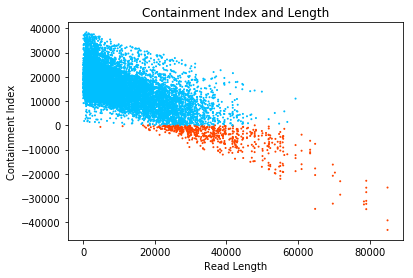

R^2 = 0.4717954565933939


In [6]:
import numpy as np

curColors = []
for i in range(0, len(lens)):
    if cis[i] >= 0:
        curColors.append('deepskyblue')
    else:
        curColors.append('orangered')

plt.scatter(lens, cis, s = 1, c = curColors)
plt.title('Containment Index and Length')
plt.xlabel('Read Length')
plt.ylabel('Containment Index')
plt.show()
plt.clf()
plt.cla()
plt.close()

r = np.corrcoef(lens, cis)[0][1]
print('R^2 = ' + str(r*r))

Below I compare my software's results with a length-based cutoff with a threshold set so that it removes the same number of reads as I removed.  These results show that a length-based cutoff is better able to keep the uncontained reads and reads with low containment scores than my cutoff, which is consistent with how well they are correlated.

Length threshold: 22865
Correctly removed: 15894
Correctly remaining: 571
Incorrectly removed: 30
Contained but kept: 1250
Number called as uncontained: 1821
Number called as contained: 15924


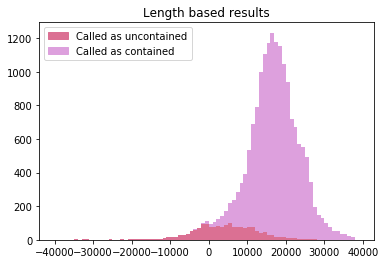

Containment Calls:
Correctly removed: 15862
Correctly remaining: 537
Incorrectly removed: 64
Contained but kept: 1282
Number called as uncontained: 1821
Number called as contained: 15924


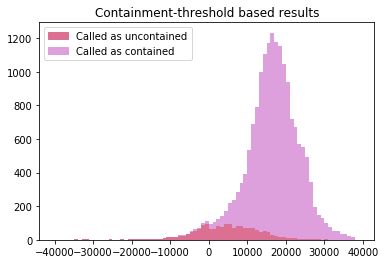

In [7]:
sortedLengths = sorted(lens)
numberContained = len(noVals)
lengthThreshold = sortedLengths[numberContained]
print('Length threshold: ' + str(lengthThreshold))

filteredYesVals = []
filteredNoVals = []
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    if lens[i] >= lengthThreshold:
        filteredYesVals.append(b)
        if cis[i] >= 0:
            fn += 1
        else:
            tn += 1
    else:
        filteredNoVals.append(b)
        if cis[i] >= 0:
            tp += 1
        else:
            fp += 1
print('Correctly removed: ' + str(tp))
print('Correctly remaining: ' + str(tn))
print('Incorrectly removed: ' + str(fp))
print('Contained but kept: ' + str(fn))        
print('Number called as uncontained: ' + str(len(filteredYesVals)))
print('Number called as contained: ' + str(len(filteredNoVals)))

colors = ['palevioletred', 'plum']
labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))

plt.title('Length based results')
plt.hist([filteredYesVals, filteredNoVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

print('Containment Calls:')
print('Correctly removed: ' + str(realTp))
print('Correctly remaining: ' + str(realTn))
print('Incorrectly removed: ' + str(realFp))
print('Contained but kept: ' + str(realFn))        
print('Number called as uncontained: ' + str(len(filteredYesVals)))
print('Number called as contained: ' + str(len(filteredNoVals)))

plt.title('Containment-threshold based results')
plt.hist([yesVals, noVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

## Combining Containment Threshold and Read Length
Based on the above results, read length is a much better proxy for containment index than the containment threshold is.  However, reads close to the average read length (15 kbp) tend to be far less correlated with read length.  In this case, incorporating the containment threshold may allow better filtering of these reads.  Here I try using a two-pass filter: first removing those reads which are very short, and then removing reads above a certain containment threshold.

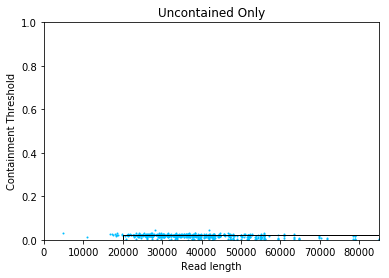

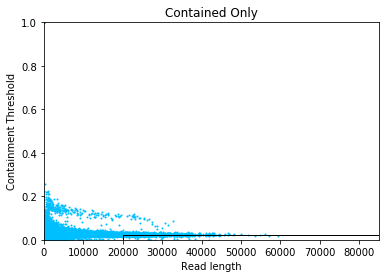

In [8]:
minLength = 20000
maxThreshold = 0.0216
        
plt.scatter(uncontainedLens, uncontainedCts, s = 1, c = 'deepskyblue')
plt.title('Uncontained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.plot([minLength, minLength], [0, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.plot([minLength, 100000], [maxThreshold, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedCts, s = 1, c = 'deepskyblue')
plt.title('Contained Only')
plt.xlabel('Read length')
plt.ylabel('Containment Threshold')
plt.xlim(min(lens), max(lens))
plt.ylim(min(cts), max(cts))
plt.plot([minLength, minLength], [0, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.plot([minLength, 100000], [maxThreshold, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.show()
plt.clf()
plt.cla()
plt.close()

Rectangle results:
Correctly removed: 15894
Correctly remaining: 571
Incorrectly removed: 30
Contained but kept: 1250
Number called as uncontained: 875
Number called as contained: 16870


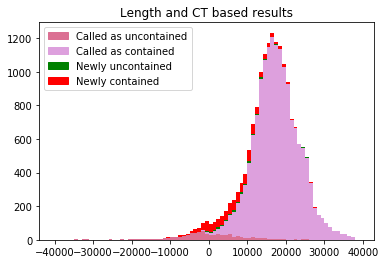

In [9]:
numberContained = len(noVals)
lengthThreshold = sortedLengths[numberContained]

combinedYes = []
combinedNo = []
newKeep = []
newThrow = []
rectFn = 0
rectTn = 0
rectFp = 0
rectTp = 0
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    ct = nameToThreshold[a]
    if lens[i] < minLength:
        if cis[i] >= 0:
            rectTp += 1
        else:
            rectFp += 1
        combinedNo.append(b)
    elif ct > maxThreshold:
        if cis[i] >= 0:
            rectTp += 1
        else:
            rectFp += 1
        if lens[i] > lengthThreshold:
            newThrow.append(b)
        else:
            combinedNo.append(b)
    else:
        if cis[i] >= 0:
            rectFn += 1
        else:
            rectTn += 1
        if lens[i] > lengthThreshold:
            combinedYes.append(b)
        else:
            newKeep.append(b)
            
numberContained = len(combinedNo) +  len(newThrow)

print('Rectangle results:')
print('Correctly removed: ' + str(tp))
print('Correctly remaining: ' + str(tn))
print('Incorrectly removed: ' + str(fp))
print('Contained but kept: ' + str(fn))
print('Number called as uncontained: ' + str(len(combinedYes) + len(newKeep)))
print('Number called as contained: ' + str(len(combinedNo) +  len(newThrow)))

colors = ['palevioletred', 'plum', 'green', 'red']
labels = ['Called as uncontained', 'Called as contained', 'Newly uncontained', 'Newly contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length and CT based results')
plt.hist([combinedYes, combinedNo, newKeep, newThrow], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

New length threshold: 29685
Number called as uncontained: 876
Number called as contained: 16869


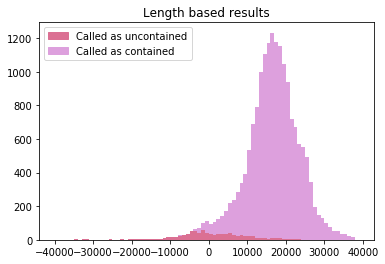

In [10]:
lengthThreshold = sortedLengths[numberContained]
print('New length threshold: ' + str(lengthThreshold))
filteredYesVals = []
filteredNoVals = []
for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    if lens[i] >= lengthThreshold:
        filteredYesVals.append(b)
    else:
        filteredNoVals.append(b)
        
print('Number called as uncontained: ' + str(len(filteredYesVals)))
print('Number called as contained: ' + str(len(filteredNoVals)))

colors = ['palevioletred', 'plum']
labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length based results')
plt.hist([filteredYesVals, filteredNoVals], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

Number called as uncontained: 875
Number called as contained: 16870
Number newly uncontained (relative to length-based): 429
Number newly contained: 428
Number correctly newly uncontained: 80
Number correctly newly contained: 308


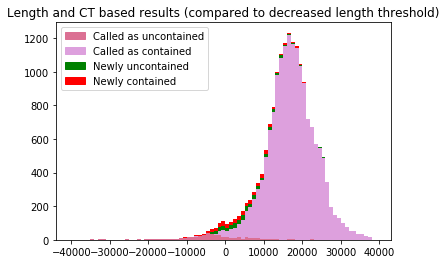

In [11]:
numberContained = len(combinedNo) +  len(newThrow)

combinedYes = []
combinedNo = []
newKeep = []
newThrow = []
correctNewThrow = 0
correctNewKeep = 0

for i in range(0, len(lens)):
    a = names[i]
    b = nameToScore[a]
    ct = nameToThreshold[a]
    if lens[i] < minLength:
        combinedNo.append(b)
    elif ct > maxThreshold:
        if lens[i] > lengthThreshold:
            if cis[i] >= 0:
                correctNewThrow += 1
            newThrow.append(b)
        else:
            combinedNo.append(b)
    else:
        if lens[i] > lengthThreshold:
            combinedYes.append(b)
        else:
            if cis[i] < 0:
                correctNewKeep += 1
            newKeep.append(b)
            
print('Number called as uncontained: ' + str(len(combinedYes) + len(newKeep)))
print('Number called as contained: ' + str(len(combinedNo) +  len(newThrow)))
print('Number newly uncontained (relative to length-based): ' + str(len(newKeep)))
print('Number newly contained: ' + str(len(newThrow)))
print('Number correctly newly uncontained: ' + str(correctNewKeep))
print('Number correctly newly contained: ' + str(correctNewThrow))

colors = ['palevioletred', 'plum', 'green', 'red']
labels = ['Called as uncontained', 'Called as contained', 'Newly uncontained', 'Newly contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.title('Length and CT based results (compared to decreased length threshold)')
plt.hist([combinedYes, combinedNo, newKeep, newThrow], color = colors , bins = buckets, stacked = True)
plt.legend(handles=legendHandles)
plt.show()
plt.clf()
plt.cla()
plt.close()

## More Theoretical Results
Note: These results are for a normal read length distribution similar to CCS reads.  Further work will be done to repeat it for log-normal read length distribution.

Given a particular read with a fixed length, what is the probability of it being contained?  This is given by a formula which considers all possible placements of the start point of the containing read, and calculates the probability that the read is long enough to contain the given read.

Let P be the probability that a read R' contains a given read R of length L, and assume that the genome length is much larger than the read length (so edge effects can be ignored).  Then, we iterate over the length D by which the prefix of R' overhangs R, and add to R' the term 1 / genomeLength * p(len(R') >= len(R) + D), which can be computed using normal_cdf.  Then, the probability that R is uncontained is the probability that all other reads fail to contain it, or (1 - P) ^ N, where N is the total number of reads.  We assume for simplicity that since the genome length is much larger than the read length, the number of reads will get arbitrarily close to its expected value genomeLength * coverage / (mean read length), and use that value for N.

Now, because the genome length is so large, the probability of each read containing a given read will be small (but the number of reads is large enough that their aggregate probability is significant).  In order to reduce the impact of numerical stability on computing such probabilities, we add an additional assumption to obtain a closed form probability that a read is uncontained.  Let S be the summation used in the computation of P, ignoring the division by the length of the genome G (equal to P * G).  Then, the probability that R is uncontained is equal to (1 - (P / G)) ^ N.  This can be rewritten as (1 - (P / G)) ^ (G * C / M), where C is the coverage and M is the mean read length.  This is then equivalent to ((1 - (P / G)) ^ G) ^ (C / M), by properties of exponents, and the term ((1 - (P / G)) ^ G) is known to be e^(-P) as G approaches infinity, which we can use as a close approximation since G >> L.  Therefore, the probability that R is contained is 1 - (e ^ (-P * C / M)), and P can be calculated as the sum of normal_cdf terms as in the code below.

In [12]:
from math import log
import numpy as np

intervalfn = 'simulatedintervals.txt'

logReadLengths = []
readLengths = []
with open(intervalfn) as f:
    for line in f:
        tokens = line.split()
        start = int(tokens[1])
        end = int(tokens[2])
        curLen = log(end - start)
        readLengths.append(end - start)
        logReadLengths.append(curLen)
        
avgLogLength = np.average(logReadLengths)
avgLength = np.average(readLengths)
print('Log mean: ' + str(avgLogLength))
print('Mean: ' + str(avgLength))
      
stdevLogLength = np.std(logReadLengths)
stdevLength = np.std(readLengths)
print('Log stdev: ' + str(stdevLogLength))
print('Stdev: ' + str(stdevLength))

Log mean: 8.392622364354585
Mean: 8454.027500704424
Log stdev: 1.1848953258658734
Stdev: 10058.587780610218


coverage = 5: 


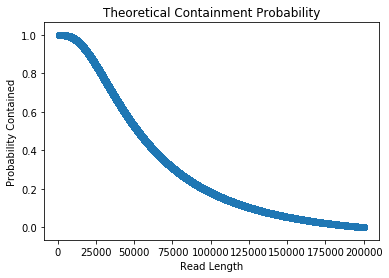

coverage = 15: 


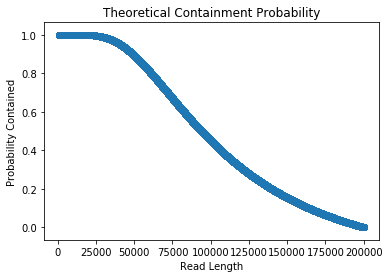

coverage = 30: 


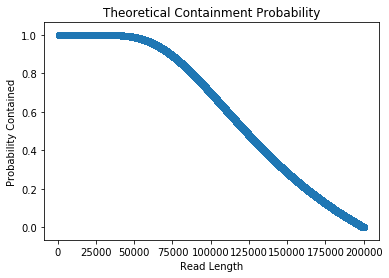

coverage = 60: 


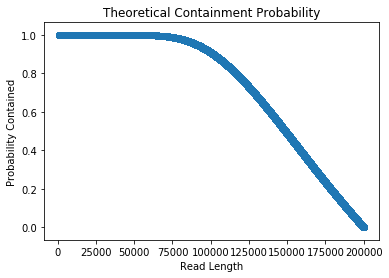

In [13]:
from math import *
def normalCdf(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

def plot(genomeLength = 5000000, coverage = 30, logMean = avgLogLength, logStdev = stdevLogLength, maxLen = 200000, min = 1000, max = 200000, verbose = False, ret = False):

    # The probability that a read is at least a given length
    probAtLeastLength = [0 for i in range(0,  maxLen+1)]
    probAtLeastLength[0] = 1
    for i in range(1, len(probAtLeastLength)):
        probAtLeastLength[i] = 1 - normalCdf((log(i) - logMean) / logStdev)

    # The summation from i to maxLen of probAtLeastLength[i]
    # Used to speed up the computation of this summation
    cSum = [0 for i in range(0, len(probAtLeastLength))]
    cSum[len(cSum)-1] = probAtLeastLength[len(cSum) - 1]
    for i in range(len(cSum)-2, -1, -1):
        cSum[i] = cSum[i+1] + probAtLeastLength[i]

    pc = [0 for i in range(0,  maxLen+1)]

    lens = []
    pcs = []
    for L in range(min, max):
        sum = cSum[L+1]
        lens.append(L)
        prob = 1 - exp(-sum * coverage / np.exp(logMean))
        pcs.append(prob)
        pc[L] = prob
        if verbose and  (L % 1000 == 0):
            print("Length " + str(L) + " contained with probability " + str(prob))

    if not ret:
        plt.scatter(lens, pcs)
        plt.title('Theoretical Containment Probability')
        plt.xlabel('Read Length')
        plt.ylabel('Probability Contained')
        plt.show()
    if ret:
        return pcs[int(exp(logMean) - min)]
    
for cov in [5, 15, 30, 60]:
    print('coverage = ' + str(cov) + ': ')
    plot(coverage = cov)


### A few observations
1. The probability of a read being uncontained given its length decreases exponentially with the coverage (i.e., doubling the coverage results in this probability being squared)
2. The probability of a read being contained given its length with a fixed coverage is independent of genome length as long as the genome length is sufficiently higher than the read length.

## Looking at kmer frequencies

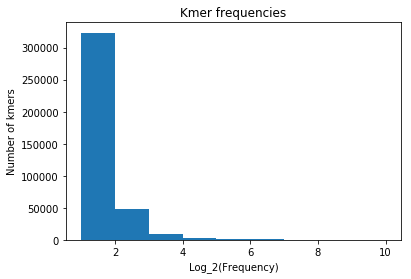

In [14]:
genomeFn  = 'simulatedgenome.txt'
kmerFreq = dict()
k = 15
with open(genomeFn) as f:
    for line in f:
        if line[0] == '>':
            continue
        for i in range(0, len(line) - k):
            cur = line[i:i+k]
            if not cur in kmerFreq:
                kmerFreq[cur] = 0
            kmerFreq[cur] = 1 + kmerFreq[cur]
            
fs = []
maxFreq = 0
maxLogFreq = 0
for x in kmerFreq:
    logFreq = log(kmerFreq[x], 2)
    if kmerFreq[x] > maxFreq:
        maxFreq = kmerFreq[x]
        maxLogFreq = logFreq
    fs.append(logFreq)
    
ff = [0 for i in range(0,  1 + maxFreq)]
for x in kmerFreq:
    cur = kmerFreq[x]
    ff[cur] = 1 + ff[cur]
for x in range(0, len(ff)):
    y = ff[x]
    if y == 0:
        continue
    #print(str(x) + ": " + str(y))
plt.hist(fs, bins = [i for i in range(1, 1+int(maxLogFreq))])
plt.title('Kmer frequencies')
plt.xlabel('Log_2(Frequency)')
plt.ylabel('Number of kmers')
plt.show()

Correctly removed: 3350
Correctly remaining: 601
Incorrectly removed: 0
Contained but kept: 13794


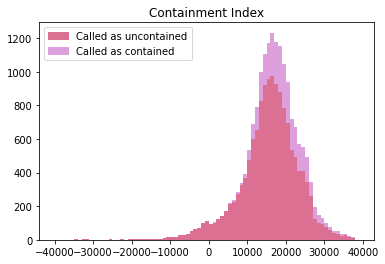

Correctly removed: 4935
Correctly remaining: 600
Incorrectly removed: 1
Contained but kept: 12209


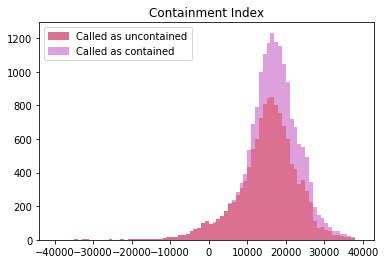

Correctly removed: 6214
Correctly remaining: 599
Incorrectly removed: 2
Contained but kept: 10930


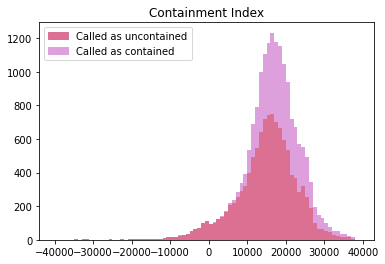

Correctly removed: 9279
Correctly remaining: 566
Incorrectly removed: 35
Contained but kept: 7865


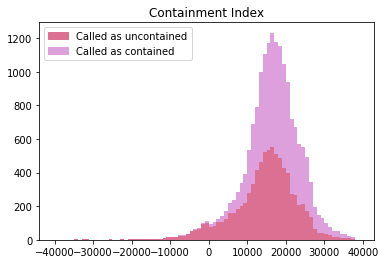

Correctly removed: 11367
Correctly remaining: 529
Incorrectly removed: 72
Contained but kept: 5777


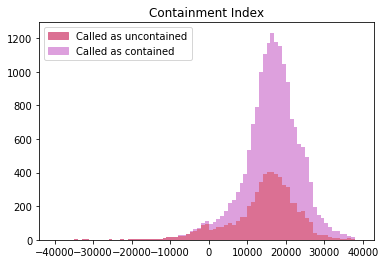

In [15]:
def plotCI(ctThreshold, endThreshold, lengthCutoff):
    yesVals = []
    noVals = []
    
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    
    for i in range(0, len(names)):
        ctContained = False
        endContained = False
        if cts[i] > ctThreshold:
            ctContained = True
        if cts[i] > .5 * ctThreshold - 1e-9 and lens[i] < lengthCutoff:
            ctContained = True
        if minEnd[i] > endThreshold:
            endContained = True
        if minEnd[i] > .5 * endThreshold - 1e-9 and lens[i] < lengthCutoff:
            endContained = True
        
        if ctContained and endContained:
            if cis[i] >= 0:
                tp += 1
            else:
                fp += 1
            noVals.append(cis[i])
        else:
            if cis[i] >= 0:
                fn += 1
            else:
                tn += 1
            yesVals.append(cis[i])
    print('Correctly removed: ' + str(tp))
    print('Correctly remaining: ' + str(tn))
    print('Incorrectly removed: ' + str(fp))
    print('Contained but kept: ' + str(fn))
    
    colors = ['palevioletred', 'plum']
        
    plt.hist([yesVals, noVals], color = colors , bins = buckets, stacked = True)

    labels = ['Called as uncontained', 'Called as contained']
    legendHandles = []
    for i in range(0, len(colors)):
        legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
    plt.legend(handles=legendHandles)
    plt.title('Containment Index')

    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    
plotCI(.05, .05, 12000)
plotCI(.04, .04, 12000)
plotCI(.03, .03, 12000)
plotCI(.02, .02, 12000)
plotCI(.01, .01, 12000)

## Combining Total Containment and End Containment
Here I try combining the total containment and end containment by taking the minimum of them for each read - removing reads for which min(total containment, end containment) is above a particular threshold is the same as checking first that the total containment is above that threshold and then that the end containment is also above that threshold, so I have plotted min(total containment, end containment) to see how it correlates with read length and containment index.  I refer to this quantity as the TEM (total-end minimum) score below for brevity.

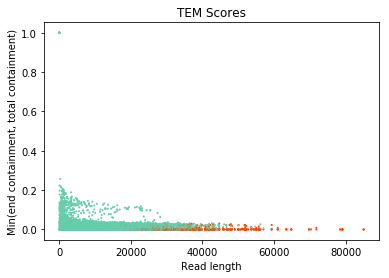

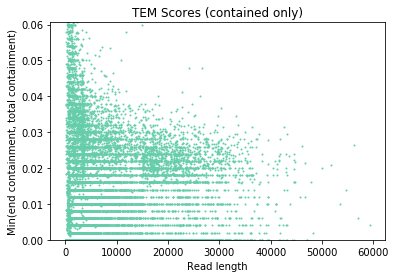

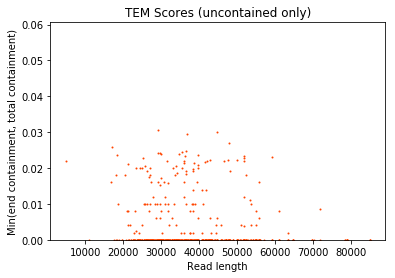

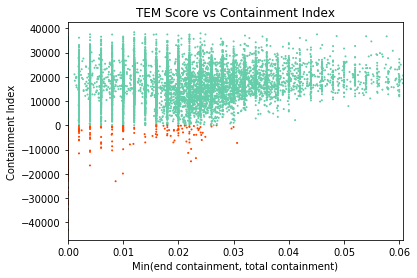

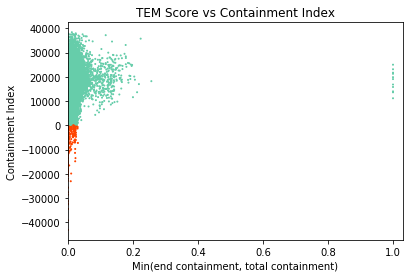

R^2 = 0.011811122254430442


In [16]:
uncontainedMEC = []
containedMEC = []
minEndOrCt = []
curColors = []
curContainedColor = 'mediumaquamarine'
curUncontainedColor = 'orangered'

for i in range(0, len(lens)):
    curMin = min(minEnd[i], cts[i])
    minEndOrCt.append(curMin)
    if cis[i] >= 0:
        curColors.append(curContainedColor)
        containedMEC.append(curMin)
    else:
        curColors.append(curUncontainedColor)
        uncontainedMEC.append(curMin)
        
plt.scatter(lens, minEndOrCt, s = 1, c = curColors)
plt.xlabel('Read length')
plt.ylabel('Min(end containment, total containment)')
plt.title('TEM Scores')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(containedLens, containedMEC, s = 1, c = curContainedColor)
plt.ylim(0, max(uncontainedMEC)+0.03)
plt.xlabel('Read length')
plt.ylabel('Min(end containment, total containment)')
plt.title('TEM Scores (contained only)')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(uncontainedLens, uncontainedMEC, s = 1, c = curUncontainedColor)
plt.ylim(0, max(uncontainedMEC)+0.03)
plt.xlabel('Read length')
plt.ylabel('Min(end containment, total containment)')
plt.title('TEM Scores (uncontained only)')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(minEndOrCt, cis, s = 1, c = curColors)
plt.xlim(0, max(uncontainedMEC)+0.03)
plt.xlabel('Min(end containment, total containment)')
plt.ylabel('Containment Index')
plt.title('TEM Score vs Containment Index')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(minEndOrCt, cis, s = 1, c = curColors)
plt.xlim(0, max(minEndOrCt)+0.03)
plt.xlabel('Min(end containment, total containment)')
plt.ylabel('Containment Index')
plt.title('TEM Score vs Containment Index')
plt.show()
plt.clf()
plt.cla()
plt.close()

r = np.corrcoef(minEndOrCt, cis)[0][1]
print('R^2 = ' + str(r*r))

## Updated Rectangle Approach with TEM Score
Using an approach similar to the rectangle approach described above, I can apply a two-pass filter, first removing reads below a certain length, and then removing any remaining reads which have a TEM score above a certain threshold.

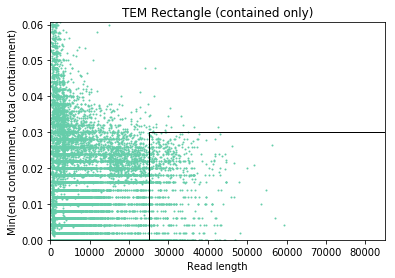

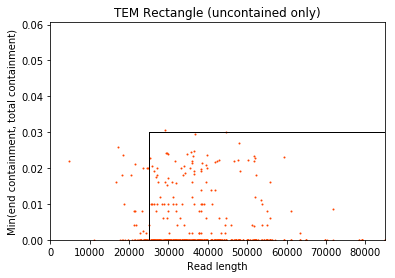

Rectangle results:
Correctly removed: 16244
Correctly remaining: 541
Incorrectly removed: 60
Contained but kept: 900


In [17]:
minLength = 25000
maxThreshold = 0.03

plt.scatter(containedLens, containedMEC, s = 1, c = curContainedColor)
plt.plot([minLength, minLength], [0, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.plot([minLength, 1e6], [maxThreshold, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.ylim(0, max(uncontainedMEC)+0.03)
plt.xlim(0, max(lens))
plt.xlabel('Read length')
plt.ylabel('Min(end containment, total containment)')
plt.title('TEM Rectangle (contained only)')
plt.show()
plt.clf()
plt.cla()
plt.close()

plt.scatter(uncontainedLens, uncontainedMEC, s = 1, c = curUncontainedColor)
plt.plot([minLength, minLength], [0, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.plot([minLength, 1e6], [maxThreshold, maxThreshold], color='k', linestyle='-', linewidth=1)
plt.ylim(0, max(uncontainedMEC)+0.03)
plt.xlim(0, max(lens))
plt.xlabel('Read length')
plt.ylabel('Min(end containment, total containment)')
plt.title('TEM Rectangle (uncontained only)')
plt.show()
plt.clf()
plt.cla()
plt.close()

rectFp = 0
rectTp = 0
rectTn = 0
rectFn = 0

rectUncontainedReadNames = []
    
for i in range(0, len(names)):
    if (lens[i] < minLength) or minEndOrCt[i] > maxThreshold:
        if cis[i] >= 0:
            rectTp += 1
        else:
            rectFp += 1
            #print(cis[i])
    else:
        rectUncontainedReadNames.append(names[i])
        if cis[i] >= 0:
            rectFn += 1
        else:
            rectTn += 1
print('Rectangle results:')
print('Correctly removed: ' + str(rectTp))
print('Correctly remaining: ' + str(rectTn))
print('Incorrectly removed: ' + str(rectFp))
print('Contained but kept: ' + str(rectFn))

In [18]:
rectNumberContained = rectTp + rectFp
newLengthThreshold  = sortedLengths[rectNumberContained]

lengthFp = 0
lengthTp = 0
lengthTn = 0
lengthFn = 0

lengthUncontainedReadNames = []
    
for i in range(0, len(names)):
    if lens[i] < newLengthThreshold:
        if cis[i] >= 0:
            lengthTp += 1
        else:
            lengthFp += 1
            #print(cis[i])
    else:
        lengthUncontainedReadNames.append(names[i])
        if cis[i] >= 0:
            lengthFn += 1
        else:
            lengthTn += 1
print('New length results')
print('New length threshold: ' + str(newLengthThreshold))
print('Length based results:')
print('Correctly removed: ' + str(lengthTp))
print('Correctly remaining: ' + str(lengthTn))
print('Incorrectly removed: ' + str(lengthFp))
print('Contained but kept: ' + str(lengthFn))

New length results
New length threshold: 25200
Length based results:
Correctly removed: 16240
Correctly remaining: 539
Incorrectly removed: 62
Contained but kept: 904


## Coverage Profile
Here I look at the number of bases with each amount of coverage.  I leave out 1000 bases from each end of the genome to avoid edge effects (for example, the entire dataset lacked any reads covering the first 200 bases).  By investigating this, we can see how well different methods maintain non-zero coverage and how they shift the rest of the distribution.

Coverage for all reads
Number of reads: 17745.0
Total read length: 150016718
Number of bases with < 10x coverage: [0, 359, 559, 223, 625, 69, 88, 488, 533, 288]


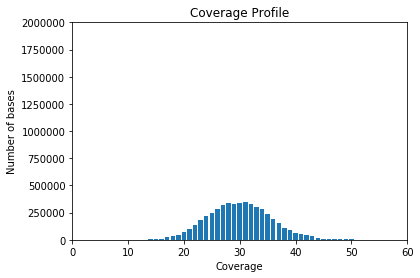

Coverage for reads called as uncontained
Number of reads: 1819.0
Total read length: 51607443
Number of bases with < 10x coverage: [4392, 24624, 28455, 54552, 157419, 182053, 260448, 390768, 489135, 561683]


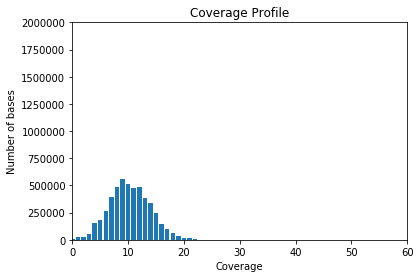

Coverage for reads called as uncontained with rectangle
Number of reads: 1441.0
Total read length: 49233486
Number of bases with < 10x coverage: [0, 12089, 14497, 95646, 136680, 214745, 349151, 421921, 577103, 595032]


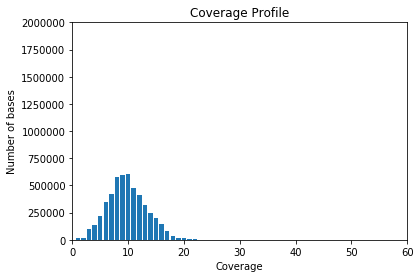

Coverage for reads called as uncontained with new length threshold
Number of reads: 1443.0
Total read length: 49376417
Number of bases with < 10x coverage: [0, 12089, 14825, 100102, 153115, 193815, 328443, 411182, 600673, 618437]


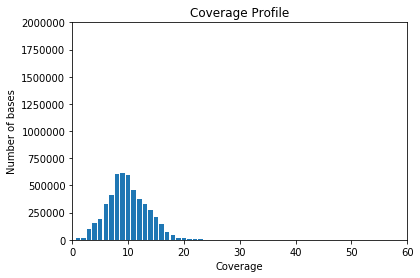

In [19]:
intervalfn = 'simulatedintervals.txt'

def getCoverage(filterNames = set()):
    with open(intervalfn) as f:
        ints = []
        totalLength = 0
        for line in f:
            tokens = line.split()
            if len(filterNames) > 0 and not tokens[0] in filterNames:
                continue
            totalLength += int(tokens[2]) - int(tokens[1])
            ints.append((int(tokens[1]), 1))
            ints.append((int(tokens[2]), -1))
        print('Number of reads: ' + str(len(ints)/2))
        print('Total read length: ' + str(totalLength))
        ints.sort()
        maxCoverage = 60
        last = 1000 # Set to ignore edge effects
        curCov = 0
        realMaxCov = 0
        vals = [0 for i in range(0, maxCoverage + 1)]
        for i in range(0, len(ints)):
            if ints[i][0] > last:
                vals[curCov] += ints[i][0] - last
                last = ints[i][0]
            curCov += ints[i][1]
            if curCov > realMaxCov:
                realMaxCov = curCov
        print('Number of bases with < 10x coverage: ' + str(vals[0:10]))
        vals = vals[0:realMaxCov+1]
        plt.bar([i for i in range(0, len(vals))], vals)
        plt.ylim(0, 2000000)
        plt.xlim(0, maxCoverage)
        plt.xlabel('Coverage')
        plt.ylabel('Number of bases')
        plt.title('Coverage Profile')
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()
        
            
print('Coverage for all reads')
getCoverage()

print('Coverage for reads called as uncontained')
getCoverage(yes)

print('Coverage for reads called as uncontained with rectangle')
getCoverage(rectUncontainedReadNames)

print('Coverage for reads called as uncontained with new length threshold')
getCoverage(lengthUncontainedReadNames)

## More Math
Expected number of shared minimizers between a read and the read containing it (assuming no repeats):

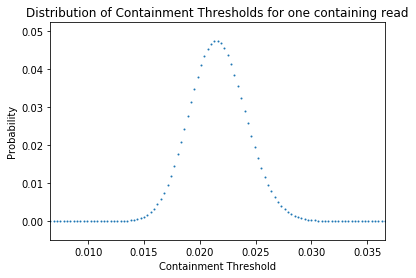

Mean: 0.0216
Stdev: 0.0025180679233504926


In [20]:
import scipy, scipy.stats

L = 10000.0
w = 5.0
numTrials = int(2.0*L/(w+1) + .5)
p = .0216
x = [i for i in range(0, numTrials+1)]
pmf = scipy.stats.binom.pmf(x, numTrials,p)
for i in range(0, len(x)):
    x[i] /= numTrials
import pylab
plt.scatter(x,pmf, s = 1)
plt.xlabel('Containment Threshold')
plt.ylabel('Probability')
plt.title('Distribution of Containment Thresholds for one containing read')
plt.xlim((numTrials * p - 50) / numTrials, (numTrials *p + 50) / numTrials)
plt.show()

print('Mean: ' + str(numTrials * p / numTrials))
print('Stdev: ' + str(sqrt(numTrials * p * (1 - p)) / numTrials))

3333


(array([4.0000e+00, 1.6000e+01, 6.4000e+01, 2.2800e+02, 7.9400e+02,
        1.9970e+03, 4.6510e+03, 8.9440e+03, 1.5142e+04, 2.3010e+04,
        3.1429e+04, 3.8668e+04, 4.3859e+04, 4.6781e+04, 4.6286e+04,
        4.3401e+04, 3.9130e+04, 3.4143e+04, 2.8468e+04, 2.3023e+04,
        1.8285e+04, 1.3965e+04, 1.0700e+04, 7.9270e+03, 5.6560e+03,
        4.0090e+03, 2.9260e+03, 2.0910e+03, 1.4380e+03, 1.0080e+03,
        6.6400e+02, 4.5700e+02, 2.9600e+02, 1.9800e+02, 1.1100e+02,
        7.9000e+01, 5.9000e+01, 4.2000e+01, 2.3000e+01, 1.1000e+01,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.02250225, 0.02280228, 0.02310231, 0.02340234, 0.02370237,
        0.0240024 , 0.02430243, 0.02460246, 0.02490249, 0.02520252,
        0.02550255, 0.02580258, 0.02610261, 0.02640264, 0.02670267,
        0.0270027 , 0.02730273, 0.02760276, 0.02790279, 0.02820282,
        0.02850285, 0.02880288, 0.02910291, 0.02940294, 0.

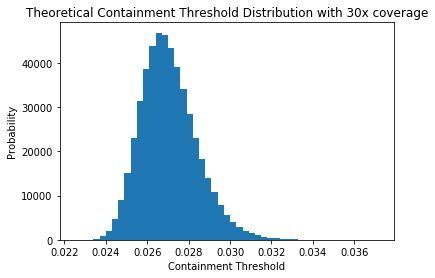

In [21]:
def binomMax(n, p, k):
    max = 0
    for i in range(0, k):       
        cur = np.random.binomial(n, p)
        if cur > max:
            max = cur
    return max

numTrials = int(2.0*L/(w+1) + .5)
p = .0216
samples = []
print(numTrials)
for i in range(0, 500000):
    samples.append(binomMax(numTrials, p, 30) / numTrials)
plt.title('Theoretical Containment Threshold Distribution with 30x coverage')
plt.xlabel('Containment Threshold')
plt.ylabel('Probability')
plt.hist(samples, bins = [i * 1.0 / numTrials for i in range(75, 125)])

(array([1.4000e+04, 7.6910e+03, 6.9930e+03, 7.1290e+03, 7.4950e+03,
        8.0870e+03, 8.6260e+03, 9.1700e+03, 9.5740e+03, 9.9120e+03,
        1.0480e+04, 1.0574e+04, 1.0883e+04, 1.0748e+04, 1.0178e+04,
        9.7790e+03, 9.2360e+03, 8.4760e+03, 7.6310e+03, 6.8780e+03,
        6.3100e+03, 5.6680e+03, 5.0490e+03, 4.4040e+03, 3.8460e+03,
        3.2540e+03, 2.7300e+03, 2.1360e+03, 1.6020e+03, 1.1800e+03,
        8.6100e+02, 5.7600e+02, 4.1400e+02, 2.4500e+02, 1.4700e+02,
        1.1400e+02, 6.2000e+01, 4.9000e+01, 2.9000e+01, 2.7000e+01,
        8.0000e+00, 6.0000e+00, 6.0000e+00, 5.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00]),
 array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49]),
 <a li

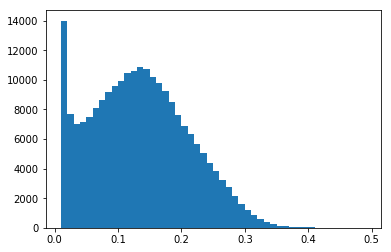

In [22]:
realfn = '../realresults/rect_025_20k.debug.txt'
realcts = []
with open(realfn) as f:
    for line in f:
        tokens = line.split(' ')
        realcts.append(float(tokens[2]))
plt.hist(realcts, bins = [0.01 * i for i in range(1, 50)])